In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import pandas as pd, numpy as np, os, sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from IPython.display import display, HTML
from IPython.core.debugger import Tracer
from IPython.core.debugger import Pdb

font = {'size'   : 18}
matplotlib.rc('font', **font)

def plotHorizontalBars(series, xlabel, title):
    xpos = np.arange(len(series.index), 0, -1)
    plt.barh(xpos, series, align='center', alpha=0.5, color='g')
    plt.grid(axis='x')
    plt.yticks(xpos, series.index)
    plt.xlabel(xlabel)
    plt.title(title)

def plotVerticalBars(series, ylabel, title):
    xpos = np.arange(len(series.index), 0, -1)
    plt.bar(xpos, series, align='center', alpha=0.5, color='g')
    plt.grid(axis='y')
    plt.xticks(xpos, series.index)
    plt.ylabel(ylabel)
    plt.title(title)

def greaterThanProbs(x, y, binSize, positiveClass=True, minx=None, maxx=None, minCnt=20):
    """
    both x is numeric and y is categorical. returns y's probabilities in each x bin
    """
    assert(y is not None)
    
    binDF = pd.concat([x,y], axis=1, ignore_index=True)
    binDF.columns = ['x', 'y']
    if minx is None:
        minx = binDF.x.min()
    if maxx is None:
        maxx = binDF.x.max()

    minx, maxx = [minx, maxx]
    bins = np.arange(minx, maxx*1.0001, binSize)
    rsDF = pd.DataFrame(bins, columns=[x.name])
    rsDF['bucket'] = '>= '
    rsDF['bucket'] = rsDF.bucket.map(str) + rsDF[x.name].map(lambda x: '{:.3f}'.format(x))

    freqCol = 'freq'
    rsDF[freqCol] = [binDF.loc[binDF.x >= thresh, 'y'].shape[0] for thresh in bins]
    rsDF['freq_pct'] = rsDF[freqCol]/x.shape[0]
    
    def prob(threshold):
        aa = binDF[binDF.x >= threshold]
        if aa.shape[0] == 0:
            return 0.0
        
        aaPos = binDF[binDF.y == positiveClass]
        return float(aaPos.shape[0])/float(aa.shape[0])

    rsDF['prob'] = [prob(thresh) for thresh in bins]
    
    rsDF = rsDF[rsDF[freqCol] >= minCnt].copy()
    return rsDF

def greaterThanProbs(x, y, binSize, positiveClass=True, minx=None, maxx=None, minCnt=20):
    """
    both x is numeric and y is categorical. returns y's probabilities in each x bin
    """
    assert(y is not None)
    
    binDF = pd.concat([x,y], axis=1, ignore_index=True)
    binDF.columns = ['x', 'y']
    if minx is None:
        minx = binDF.x.min()
    if maxx is None:
        maxx = binDF.x.max()

    minx, maxx = [minx, maxx]
    bins = np.arange(minx, maxx*1.0001, binSize)
    rsDF = pd.DataFrame(bins, columns=[x.name])
    rsDF['bucket'] = '>= '
    rsDF['bucket'] = rsDF.bucket.map(str) + rsDF[x.name].map(lambda x: '{:.3f}'.format(x))

    freqCol = 'freq'
    rsDF[freqCol] = [binDF.loc[binDF.x >= thresh, 'y'].shape[0] for thresh in bins]
    rsDF['freq_pct'] = rsDF[freqCol]/x.shape[0]
    
    def prob(threshold):
        aa = binDF[binDF.x >= threshold]
        if aa.shape[0] == 0:
            return 0.0
        
        aaPos = binDF[binDF.y == positiveClass]
        return float(aaPos.shape[0])/float(aa.shape[0])

    rsDF['prob'] = [prob(thresh) for thresh in bins]
    
    rsDF = rsDF[rsDF[freqCol] >= minCnt].copy()
    return rsDF

def greaterThanStats(x, y, binSize, minx=None, maxx=None, minCnt=20):
    """
    both x and y are numeric. If y = None, y will be set to x
    """
    if y is None:
        y = x
    binDF = pd.concat([x,y], axis=1, ignore_index=True)
    binDF.columns = ['x', 'y']
    if minx is None:
        minx = binDF.x.min()
    if maxx is None:
        maxx = binDF.x.max()

    minx, maxx = [minx, maxx]
    bins = np.arange(minx, maxx*1.0001, binSize)
    rsDF = pd.DataFrame(bins, columns=[x.name])
    rsDF['bucket'] = '>= ' + rsDF[x.name]

    freqCol = 'freq'
    rsDF[freqCol] = [binDF.loc[binDF.x >= thresh, 'y'].shape[0] for thresh in bins]
    rsDF['freq_pct'] = rsDF[freqCol]/x.shape[0]

    meanCol = '{}_mean'.format(y.name)
    rsDF[meanCol] = [np.mean(binDF.loc[binDF.x >= thresh, 'y']) for thresh in bins]

    sumCol = '{}_sum'.format(y.name)
    rsDF[sumCol] = [np.sum(binDF.loc[binDF.x >= thresh, 'y']) for thresh in bins]
    totY = y.sum()
    rsDF['sum_pct'] = rsDF[sumCol]/totY
    
    rsDF = rsDF[rsDF[freqCol] >= minCnt].copy()
    return rsDF

def lessThanStats(x, y, binSize, minx=None, maxx=None, minCnt=20):
    """
    both x and y are numeric. If y = None, y will be set to x
    """
    if y is None:
        y = x
    binDF = pd.concat([x,y], axis=1, ignore_index=True)
    binDF.columns = ['x', 'y']
    if minx is None:
        minx = binDF.x.min()
    if maxx is None:
        maxx = binDF.x.max()

    bins = np.arange(maxx, minx, -binSize)
    rsDF = pd.DataFrame(bins, columns=[x.name])

    freqCol = 'freq'
    rsDF[freqCol] = [binDF.loc[binDF.x <= thresh, 'y'].shape[0] for thresh in bins]
    rsDF['freq_pct'] = rsDF[freqCol]/x.shape[0]

    meanCol = '{}_mean'.format(y.name)
    rsDF[meanCol] = [np.mean(binDF.loc[binDF.x <= thresh, 'y']) for thresh in bins]

    sumCol = '{}_sum'.format(y.name)
    rsDF[sumCol] = [np.sum(binDF.loc[binDF.x <= thresh, 'y']) for thresh in bins]
    totY = y.sum()
    rsDF['sum_pct'] = rsDF[sumCol]/totY
    
    rsDF = rsDF[rsDF[freqCol] >= minCnt].copy()
    return rsDF

In [3]:
%%time
cacheDir = '/Users/huiwang/dev/PTG_DataScience/spark_cache'
inFile = '{}/test_profile_TY2015.csv'.format(cacheDir)
allData = pd.read_csv(inFile)

CPU times: user 1.28 s, sys: 72.1 ms, total: 1.35 s
Wall time: 1.36 s


(9999, 571)

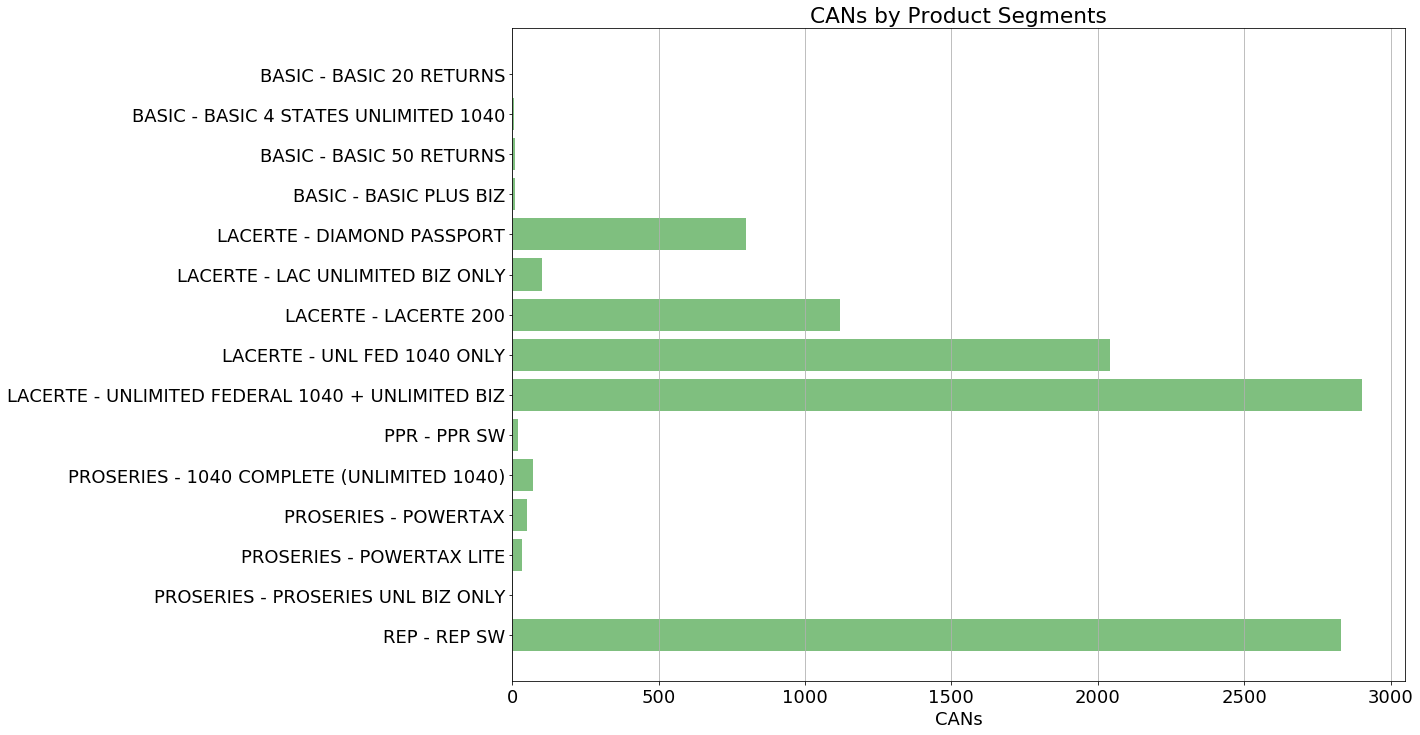

In [4]:
display(allData.shape)
a = allData.PRODUCT_GROUP + ' - ' + allData.PRODUCT_SEGMENT
a = a.value_counts().sort_index()
plt.figure(figsize=(16,12))
plotHorizontalBars(a, 'CANs', 'CANs by Product Segments')

False    5628
True      244
Name: AT_RISK, dtype: int64

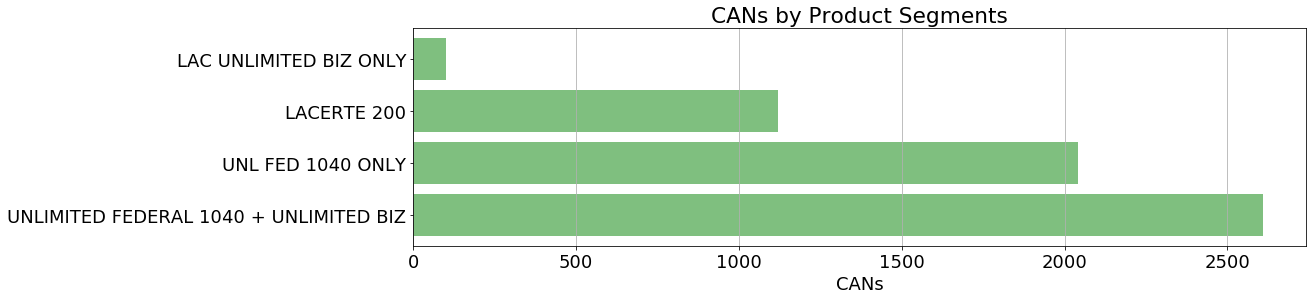

In [5]:
df = allData[(allData.PRODUCT_GROUP == 'LACERTE') & (allData.PRODUCT_SEGMENT != 'DIAMOND PASSPORT') & (~allData.IS_PM)]
display(df.AT_RISK.value_counts())

plt.figure(figsize=(16,4))
a = df.PRODUCT_SEGMENT.value_counts().sort_index()
plotHorizontalBars(a, 'CANs', 'CANs by Product Segments')

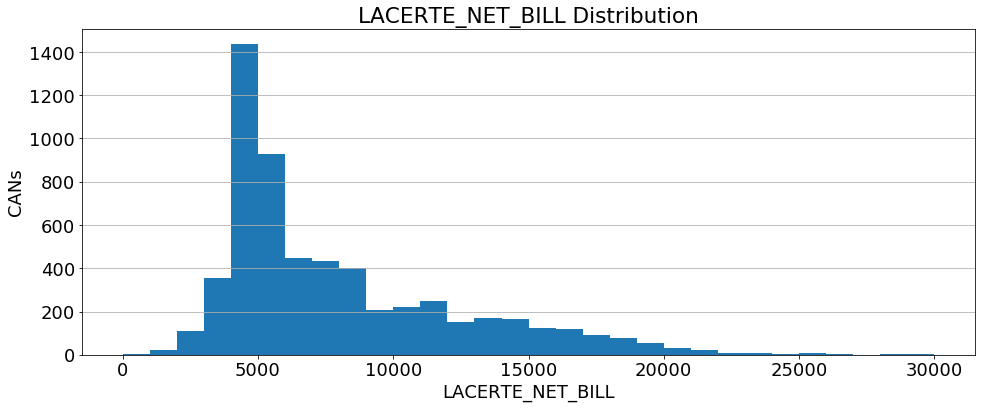

In [6]:
a = df.LACERTE_NET_BILL
plt.figure(figsize=(16,6))
plt.hist(a, bins=30, range=[0,30000])
plt.title("{} Distribution".format(a.name))
plt.grid(axis='y')
plt.xlabel(a.name)
plt.ylabel("CANs")

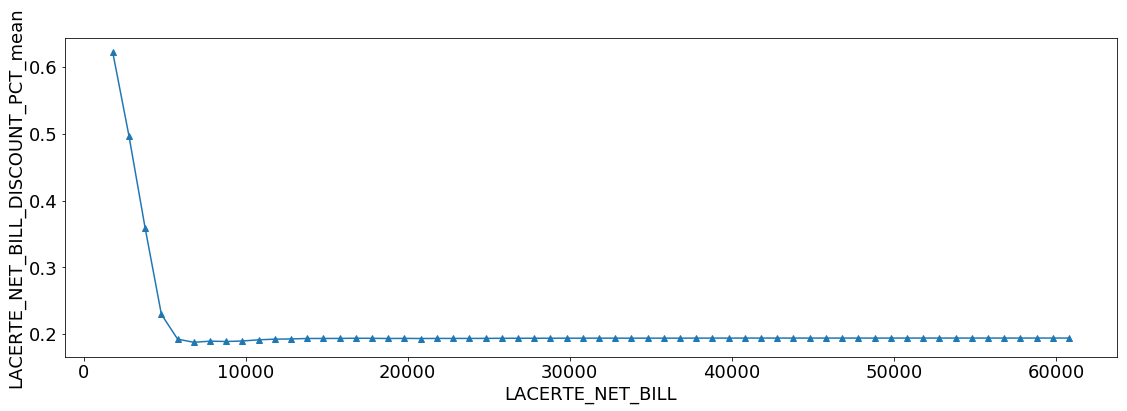

,LACERTE_NET_BILL,freq,freq_pct,LACERTE_NET_BILL_DISCOUNT_PCT_mean,LACERTE_NET_BILL_DISCOUNT_PCT_sum,sum_pct
0,60796.5,5872,1.000000,0.194174,1140.192517,1.000000
1,59796.5,5871,0.999830,0.194165,1139.942517,0.999781
2,58796.5,5871,0.999830,0.194165,1139.942517,0.999781
3,57796.5,5871,0.999830,0.194165,1139.942517,0.999781
4,56796.5,5871,0.999830,0.194165,1139.942517,0.999781
5,55796.5,5871,0.999830,0.194165,1139.942517,0.999781
6,54796.5,5871,0.999830,0.194165,1139.942517,0.999781
7,53796.5,5871,0.999830,0.194165,1139.942517,0.999781
8,52796.5,5871,0.999830,0.194165,1139.942517,0.999781
9,51796.5,5871,0.999830,0.194165,1139.942517,0.999781


In [7]:
x = df.LACERTE_NET_BILL
y = df.LACERTE_NET_BILL_DISCOUNT_PCT
stats = lessThanStats(x, y, binSize=1000, minx=0)
a = stats.sort_values(x.name)

plt.figure(figsize=(16,6))
meanCol = y.name + '_mean'
plt.plot(a[x.name], a[meanCol], marker='^')
plt.xlabel(x.name)
plt.ylabel(meanCol)
plt.tight_layout()
plt.show()

display(stats)

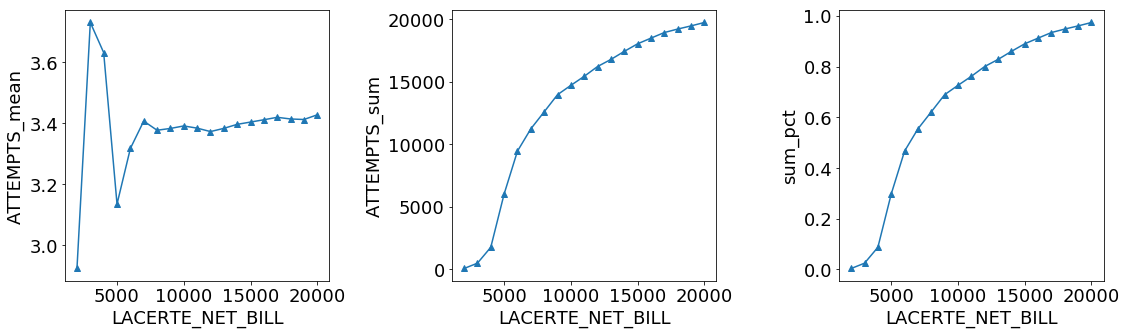

,LACERTE_NET_BILL,freq,freq_pct,ATTEMPTS_mean,ATTEMPTS_sum,sum_pct
0,20000,5757,0.980416,3.428001,19735,0.974135
1,19000,5703,0.971219,3.412590,19462,0.960659
2,18000,5626,0.958106,3.414326,19209,0.948171
3,17000,5536,0.942779,3.419798,18932,0.934498
4,16000,5418,0.922684,3.411776,18485,0.912434
5,15000,5297,0.902078,3.404191,18032,0.890074
6,14000,5130,0.873638,3.396686,17425,0.860112
7,13000,4960,0.844687,3.383468,16782,0.828373
8,12000,4808,0.818801,3.372920,16217,0.800484
9,11000,4560,0.776567,3.384211,15432,0.761736


In [8]:
x = df.LACERTE_NET_BILL
y = df.ATTEMPTS
stats = lessThanStats(x, y, binSize=1000, minx=0, maxx=20000)
a = stats.sort_values(x.name)

plt.figure(figsize=(16,5))
plt.subplot(131)
meanCol = y.name + '_mean'
plt.plot(a[x.name], a[meanCol], marker='^')
plt.xlabel(x.name)
plt.ylabel(meanCol)

plt.subplot(132)
sumCol = y.name + '_sum'
plt.plot(a[x.name], a[sumCol], marker='^')
plt.xlabel(x.name)
plt.ylabel(sumCol)

plt.subplot(133)
plt.plot(a[x.name], a['sum_pct'], marker='^')
plt.xlabel(x.name)
plt.ylabel('sum_pct')
plt.tight_layout()
plt.show()

display(stats)

In [9]:
display(np.sort(df.columns))

array(['ATTEMPTS', 'ATTEMPTS_CHANGE', 'ATTEMPTS_CHANGE_PCT', 'AT_RISK',
       'AT_RISK_COUNT', 'AT_RISK_REASON', 'BILL_COST_RATIO',
       'BILL_COST_RATIO_1015', 'BILL_COST_RATIO_1015_CHANGE',
       'BILL_COST_RATIO_CHANGE', 'BILL_FEE_RATIO', 'BILL_FEE_RATIO_1015',
       'BILL_FEE_RATIO_1015_CHANGE', 'BILL_FEE_RATIO_CHANGE',
       'BILL_INCOME_RATIO', 'BILL_INCOME_RATIO_1015',
       'BILL_INCOME_RATIO_1015_CHANGE', 'BILL_INCOME_RATIO_CHANGE',
       'BIZ_EXT_COUNT', 'BIZ_EXT_COUNT_CHANGE', 'BIZ_EXT_COUNT_CHANGE_PCT',
       'BIZ_IIT_RATIO', 'BIZ_IIT_RATIO_1015', 'BIZ_IIT_RATIO_1015_CHANGE',
       'BIZ_IIT_RATIO_CHANGE', 'BIZ_STATES_0415', 'BIZ_STATES_0415_CHANGE',
       'BIZ_STATES_1015', 'BIZ_STATES_1015_CHANGE', 'CAN', 'COHORT',
       'COST_PER_UNIT_0415', 'COST_PER_UNIT_0415_CHANGE',
       'COST_PER_UNIT_0415_CHANGE_PCT', 'COST_PER_UNIT_1015',
       'COST_PER_UNIT_1015_CHANGE', 'COST_PER_UNIT_1015_CHANGE_PCT',
       'DISCOUNT', 'DOWNGRADE', 'EFE_TOTAL_FED_0415',
       '

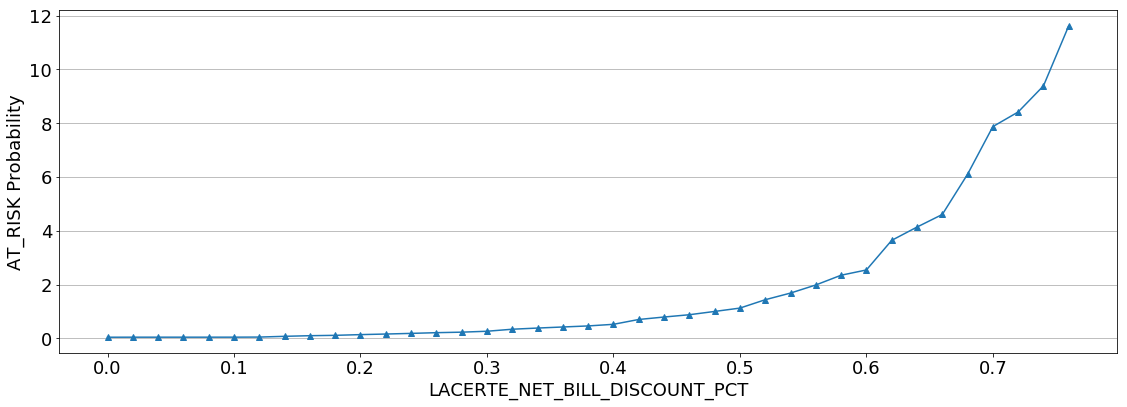

,LACERTE_NET_BILL_DISCOUNT_PCT,bucket,freq,freq_pct,prob
0,0.00,>= 0.000,5872,1.000000,0.041553
1,0.02,>= 0.020,5674,0.966281,0.043003
2,0.04,>= 0.040,5663,0.964407,0.043087
3,0.06,>= 0.060,5656,0.963215,0.043140
4,0.08,>= 0.080,5628,0.958447,0.043355
5,0.10,>= 0.100,5576,0.949591,0.043759
6,0.12,>= 0.120,5174,0.881131,0.047159
7,0.14,>= 0.140,3244,0.552452,0.075216
8,0.16,>= 0.160,2482,0.422684,0.098308
9,0.18,>= 0.180,2183,0.371764,0.111773


In [10]:
x = df.LACERTE_NET_BILL_DISCOUNT_PCT
y = df.AT_RISK
stats = greaterThanProbs(x, y, binSize=0.02)
a = stats.sort_values(x.name)

plt.figure(figsize=(16,6))
plt.plot(a[x.name], a.prob, marker='^')
plt.grid(axis='y')
plt.xlabel(x.name)
plt.ylabel(y.name+' Probability')
plt.tight_layout()
plt.show()

display(stats)

In [14]:
def inBinProbs(x, y, binSize, positiveClass=True, minx=None, maxx=None, minCnt=20):
    """
    both x is numeric and y is categorical. returns y's probabilities in each x bin
    """
    assert(y is not None)
    
    binDF = pd.concat([x,y], axis=1, ignore_index=True)
    binDF.columns = ['x', 'y']
    if minx is None:
        minx = binDF.x.min()
    if maxx is None:
        maxx = binDF.x.max()

    minx, maxx = [minx, maxx]
    bins = np.arange(minx, maxx*1.0001, binSize)
    rsDF = pd.DataFrame(bins, columns=[x.name])
    rsDF['bucket'] = rsDF[x.name].map(lambda x: '>= {:.3f}'.format(x))
    
    rsDF['freq'] = [binDF.loc[binDF.x >= thresh, 'y'].shape[0] for thresh in bins]
    rsDF['freq_pct'] = rsDF.freq/x.shape[0]
    
    def prob(bmin, bmax):
        aa = binDF[(binDF.x >= bmin) & (binDF.x < bmax)]
        if aa.shape[0] == 0:
            return 0.0
        
        aaPos = binDF[binDF.y == positiveClass]
        return float(aaPos.shape[0])/float(aa.shape[0])

    bins = bins.tolist()
    bins.append(float('inf'))
    size = len(bins)
    rsDF['prob'] = [prob(bins[i], bins[i+1]) for i in range(size-1)]
    
    rsDF = rsDF[rsDF.freq >= minCnt].copy()
    return rsDF

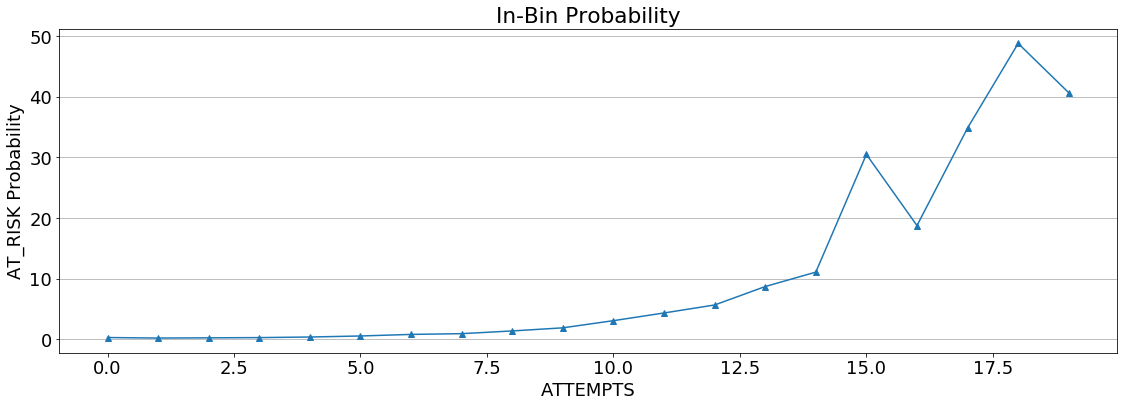

,ATTEMPTS,bucket,freq,freq_pct,prob
0,0.0,>= 0.000,5872,1.000000,0.307692
1,1.0,>= 1.000,5079,0.864952,0.218834
2,2.0,>= 2.000,3964,0.675068,0.258749
3,3.0,>= 3.000,3021,0.514475,0.296476
4,4.0,>= 4.000,2198,0.374319,0.392283
5,5.0,>= 5.000,1576,0.268392,0.563510
6,6.0,>= 6.000,1143,0.194653,0.821549
7,7.0,>= 7.000,846,0.144074,0.945736
8,8.0,>= 8.000,588,0.100136,1.394286
9,9.0,>= 9.000,413,0.070334,1.906250


In [16]:
x = df.ATTEMPTS
y = df.AT_RISK
stats = inBinProbs(x, y, binSize=1)
a = stats.sort_values(x.name)

plt.figure(figsize=(16,6))
plt.plot(a[x.name], a.prob, marker='^')
plt.grid(axis='y')
plt.xlabel(x.name)
plt.ylabel(y.name+' Probability')
plt.title("In-Bin Probability")
plt.tight_layout()
plt.show()

display(stats)